In [1]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os

In [2]:
carpeta = (os.getcwd()+'/tc02Data/')

# Nombres de los archivos: yeast_(...).txt
archivos = ['Y2H','AP-MS','LIT','LIT_Reguly']

# Lista donde se van a ir agregando los grafos en el orden de los archivos
Gs = []

for j,archivo in enumerate(archivos):
    data = pd.read_csv(carpeta+'yeast_'+archivo+'.txt', sep='\t', header=None)
    
    G = nx.Graph()
    
    for i in range(len(data)):
        G.add_edges_from([(data[0][i],data[1][i])])
    Gs.append(G)

# El último archivo, LIT_Reguly, es el único que tiene encabezado
# Quise poner header automático pero devuelve un error, así que elimino lo que sobra a lo bruto
Gs[3].remove_node("Bait gene/protein")
Gs[3].remove_node("Hit gene/protein")

In [3]:
# Proteinas esenciales
data_ess = pd.read_csv(carpeta+'Essential_ORFs_paperHe.txt', sep='\t', header=0,skipfooter=4,usecols=[1])

# Para eliminar los espacios en los nombres de las proteinas
data_ess['ORF_name'] = data_ess['ORF_name'].map(lambda x: x.strip())

ess = data_ess["ORF_name"].tolist()
del ess[0] # como antes, elimino el encabezado

# ess es la lista de proteinas esenciales

C:\Users\Luli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [4]:
# Agrego la caracteristica de ser o no esencial

for G in Gs:
    nodos_G = set(G.nodes()) # set de nodos de G
    nodos_ess_G = nodos_G.intersection(set(ess)) # nodos esenciales de G (como interseccion entre nodos de G y esenciales)
    nodos_no_ess_G = nodos_G.difference(set(ess)) # nodos no esenciales de G (como diferencia entre nodos de G y esenciales)
    
    # Agrego el atributo correspondiente a cada nodo
    G.add_nodes_from(nodos_ess_G, essential=True)
    G.add_nodes_from(nodos_no_ess_G, essential=False)

# Para comprobarlo me fije que la cantidad de nodos sea la misma antes y despues de esto

In [5]:
k_vectores = []
frac_vectores = []

for G in Gs:
    grados_dict = dict(G.degree())
    ess_dict = nx.get_node_attributes(G,'essential')

    k_lista = list(grados_dict.values()) # lista de grados de nodos en orden
    k = np.unique(k_lista) # vector de grado de nodos sin repetir

    L = len(k)
    nodos_ess = np.zeros(L)
    nodos_total = np.zeros(L)
    nodos_frac = np.zeros(L)

    for i,grado in enumerate(k):
        nodos_total[i] = k_lista.count(grado)
        # cuenta cuantas veces aparece cada grado en k_lista

    for proteina in ess_dict:
        if ess_dict[proteina] == True:
            i = np.where(k == grados_dict[proteina])
            nodos_ess[i] += 1

    nodos_frac = nodos_ess / nodos_total
    
    k_vectores.append(k)
    frac_vectores.append(nodos_frac)


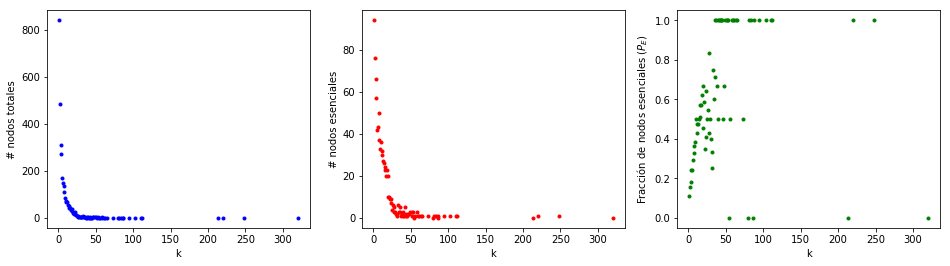

In [6]:
# Ejemplo de graficos para alguno de ellos (LIT_Reguly)
plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.plot(k,nodos_total,'.b')
plt.xlabel('k')
plt.ylabel('# nodos totales')

plt.subplot(1,3,2)
plt.plot(k,nodos_ess,'.r')
plt.xlabel('k')
plt.ylabel('# nodos esenciales')

plt.subplot(1,3,3)
plt.plot(k,nodos_frac,'.g')
plt.xlabel('k')
plt.ylabel('Fracción de nodos esenciales ($P_E$)')

plt.show()

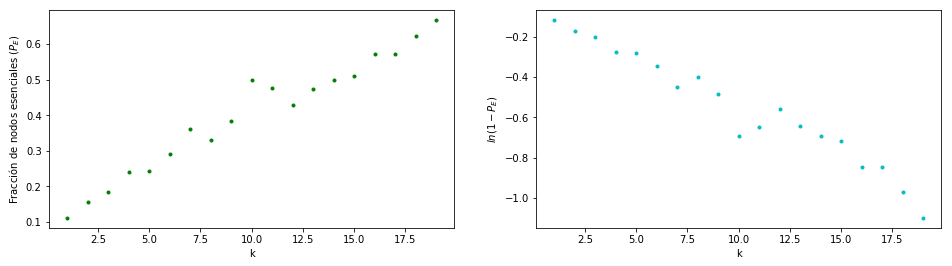

In [7]:
# Ejemplo de gráficos de los datos que se usan, para la fracción (Pe) y para ln(1-Pe)

# Ojo: truncar los datos en algún grado (en el paper lo hacen en 10)
# porque para grados mayores no hay estadistica
# NO hacer acumulativo, porque cambiaría el criterio de bineado y esta mal
# Para decidir en qué grado cortar, ver cada uno de los gráficos de Pe

menos_Pe = np.log(1 - nodos_frac[0:19])

plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
plt.plot(k[0:19],nodos_frac[0:19],'.g')
plt.xlabel('k')
plt.ylabel('Fracción de nodos esenciales ($P_E$)')

plt.subplot(1,2,2)
plt.plot(k[0:19],menos_Pe,'.c')
plt.xlabel('k')
plt.ylabel('$ln(1-P_E)$')

plt.show()

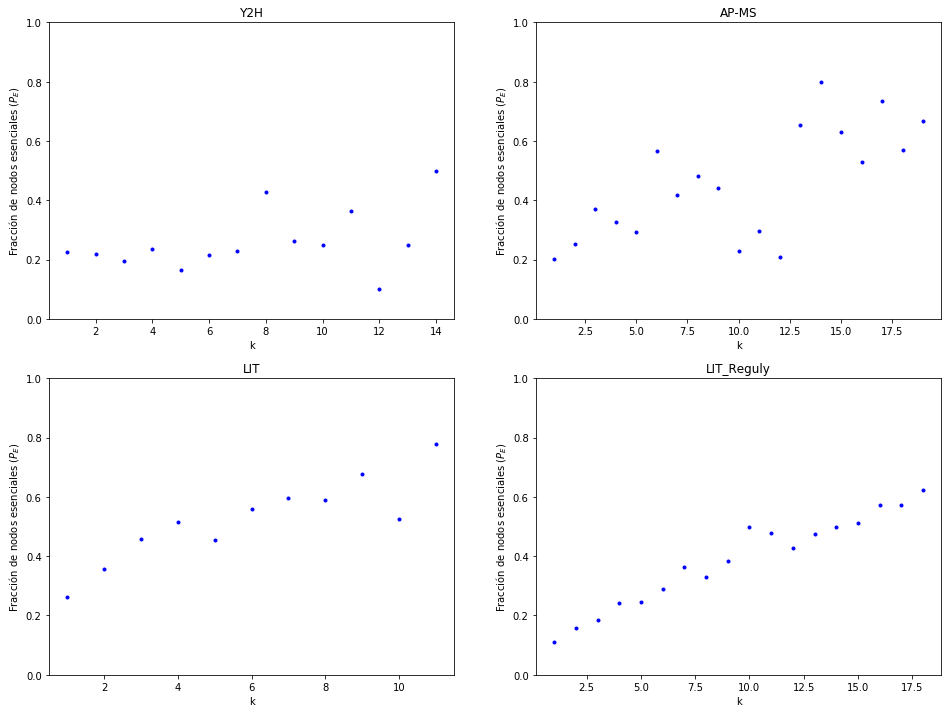

In [8]:
# Para ver donde cortar en cada caso

plt.figure(figsize=(16, 12))

plt.subplot(2,2,1)
plt.plot(k_vectores[0][0:14],frac_vectores[0][0:14],'.b')
plt.ylim([0,1])
plt.xlabel('k')
plt.ylabel('Fracción de nodos esenciales ($P_E$)')
plt.title(archivos[0])

plt.subplot(2,2,2)
plt.plot(k_vectores[1][0:19],frac_vectores[1][0:19],'.b')
plt.ylim([0,1])
plt.xlabel('k')
plt.ylabel('Fracción de nodos esenciales ($P_E$)')
plt.title(archivos[1])

plt.subplot(2,2,3)
plt.plot(k_vectores[2][0:11],frac_vectores[2][0:11],'.b')
plt.ylim([0,1])
plt.xlabel('k')
plt.ylabel('Fracción de nodos esenciales ($P_E$)')
plt.title(archivos[2])

plt.subplot(2,2,4)
plt.plot(k_vectores[3][0:18],frac_vectores[3][0:18],'.b')
plt.ylim([0,1])
plt.xlabel('k')
plt.ylabel('Fracción de nodos esenciales ($P_E$)')
plt.title(archivos[3])

plt.show()

In [9]:
k_lin = []
Pe = []

k_lin.append(k_vectores[0][0:14])
k_lin.append(k_vectores[1][0:19])
k_lin.append(k_vectores[2][0:11])
k_lin.append(k_vectores[3][0:18])

Pe.append(np.log(1-frac_vectores[0][0:14]))
Pe.append(np.log(1-frac_vectores[1][0:19]))
Pe.append(np.log(1-frac_vectores[2][0:11]))
Pe.append(np.log(1-frac_vectores[3][0:18]))

In [10]:
from scipy.stats import linregress

L = len(Pe)
slope = np.zeros(L)
intercept = np.zeros(L)
r_value = np.zeros(L)
p_value = np.zeros(L)
std_err = np.zeros(L)

for i in range(L):
    slope[i], intercept[i], r_value[i], p_value[i], std_err[i] = linregress(k_lin[i],Pe[i])

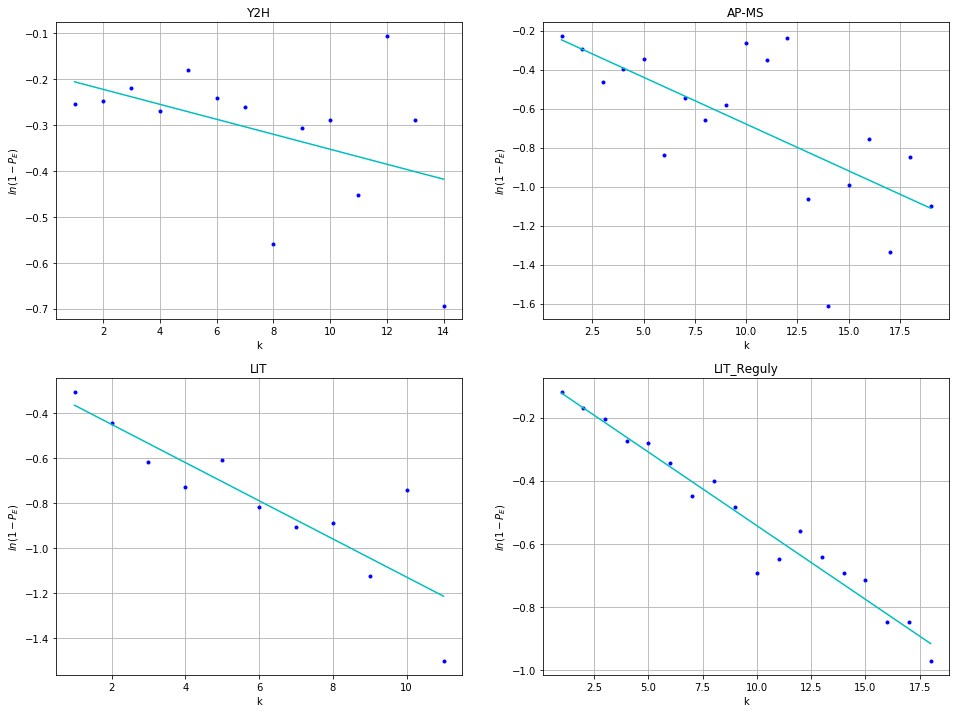

In [11]:
plt.figure(figsize=(16, 12))

for i in range(L):
    
    plt.subplot(2,2,i+1)
    plt.plot(k_lin[i],Pe[i],'.b')
    plt.plot(k_lin[i],slope[i]*k_lin[i]+intercept[i],'-c')
    plt.xlabel('k')
    plt.ylabel('$ln(1-P_E)$')
    plt.title(archivos[i])
    plt.grid()
    
plt.show()

In [12]:
import statsmodels.api as sm # para hacer el ajuste

L = len(Pe)
a = np.zeros(L) # pendientes
b = np.zeros(L) # ordenadas al origen
std_err_a = np.zeros(L)
std_err_b = np.zeros(L)
rsquared = np.zeros(L)
Y = []

for i in range(L):    
    X = k_lin[i] #variable independiente
    X = sm.add_constant(X) # agrego ordenada al origen
    model = sm.OLS(Pe[i], X) # OJO con el orden de los argumentos
    result = model.fit()
    
    b[i] = result.params[0] # constante
    a[i] = result.params[1] # pendiente
    std_err_b[i] = result.bse[0]
    std_err_a[i] = result.bse[1]
    rsquared[i] = result.rsquared
    Y.append(result.predict()) # y predecido
    
# falta calcular alpha y beta a partir de la pendiente y la ordenada al origen
alpha = 1 - np.exp(a)
beta = 1 - np.exp(b)

# Tengo a, b, std_err_a, std_err_b, alpha, beta, falta el error propagado de alpha y beta
std_err_alpha = np.exp(a)*std_err_a
std_err_beta = np.exp(b)*std_err_b

C:\Users\Luli\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


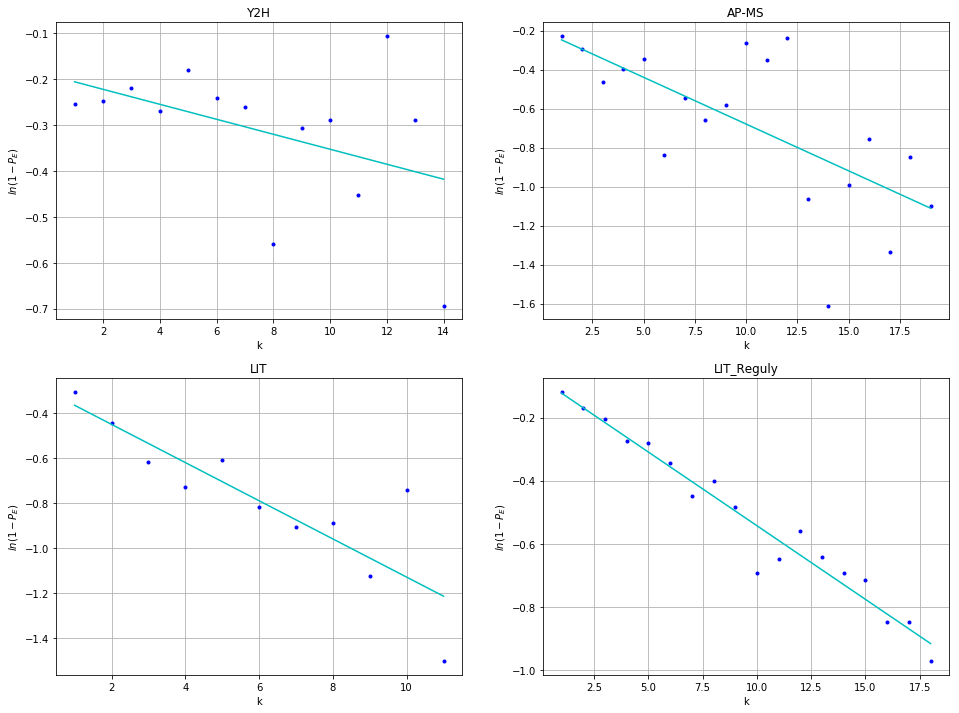

In [13]:
plt.figure(figsize=(16, 12))

for i in range(L):
    
    plt.subplot(2,2,i+1)
    plt.plot(k_lin[i],Pe[i],'.b')
    plt.plot(k_lin[i],Y[i],'-c')
    plt.xlabel('k')
    plt.ylabel('$ln(1-P_E)$')
    plt.title(archivos[i])
    plt.grid()
    
plt.show()

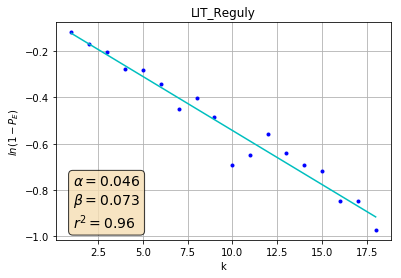

In [17]:
# Graficos para guardar

j = 3 # cambiar el indice de 0 a 3 para ver los gráficos
fig, ax = plt.subplots()
plt.plot(k_lin[j],Pe[j],'.b')
plt.plot(k_lin[j],Y[j],'-c')

# Texto que va a aparecer en un cuadro dentro del grafico con los resultados del ajuste
textstr = '\n'.join((
    r'$\alpha=%.3f$' % (alpha[j], ),
    r'$\beta=%.3f$' % (beta[j], ),
    r'$r^2=%.2f$' % (rsquared[j], )))

# Propiedades del cuadro donde aparece el texto
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# Texto ubicado en el vertice inferior izquierdo (proporciones de los ejes)
ax.text(0.05, 0.3, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('k')
plt.ylabel('$ln(1-P_E)$')
plt.title(archivos[j])
plt.grid()

#plt.savefig(archivos[j]+'.png', dpi=150)

plt.show()

In [25]:
print(beta*100)
print(std_err_beta*100)


[ 17.22264371  18.0995621   24.36748018   7.33227991]
[  6.78046793  11.86644644   8.61691526   2.52184561]


In [23]:
tabla = pd.DataFrame({"Red":archivos,
                    "Alfa":100*alpha,
                    "Beta":100*beta,
                    "Alfa std":100*std_err_alpha,
                    "Beta std":100*std_err_beta,
                    "$r^2$":rsquared
                   })
# tabla.to_csv('ajuste_lineal.txt',sep='\t')
tabla

,$r^2$,Alfa,Alfa std,Beta,Beta std,Red
0,0.193688,1.620047,0.946424,17.222644,6.780468,Y2H
1,0.455675,4.680769,1.211277,18.099562,11.866446,AP-MS
2,0.739890,8.148259,1.542950,24.367480,8.616915,LIT
3,0.955561,4.556250,0.239958,7.332280,2.521846,LIT_Reguly
